# 機械学習を用いたDモデル設計最適化のデモプログラム

サポートベクター回帰を用いてDモデルの設計変数とトルク特性の関係を関数化します。  
学習した回帰モデルを用いて、平均トルクの最大化とトルクリプルの最小化の多目的最適化を実施します。  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pymoo

In [ ]:
# ライブラリのインポート
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.core.callback import Callback
from pymoo.operators.sampling.lhs import LHS

%matplotlib inline

データの確認

電気学会のベンチマークモデルであるDモデルを使用。  
磁石の埋め込み深さと幅を変数とする。  

In [ ]:
# データの読み込み
df = pd.read_csv('/content/drive/MyDrive/demo_seminar/D-model_data.csv', index_col=0)

# ↓は講師用（ディレクトリが異なる）
# df = pd.read_csv('/content/drive/MyDrive/seminar/230804/demo_seminar/D-model_data.csv', index_col=0)

df

,d1,d2,Tavg,Trip
0,6.383348,0.731035,0.452373,0.380527
1,11.263926,0.540481,0.715745,0.768983
2,9.549675,4.195661,0.551899,0.433311
3,9.967930,2.163768,0.625701,0.579160
4,11.360032,3.508988,0.636849,0.349367
...,...,...,...,...
82,12.149055,2.713247,0.688370,0.391388
83,7.643265,2.432430,0.508353,0.305729
84,8.731968,1.984319,0.569164,0.364148
85,8.481728,0.686668,0.580297,0.441828


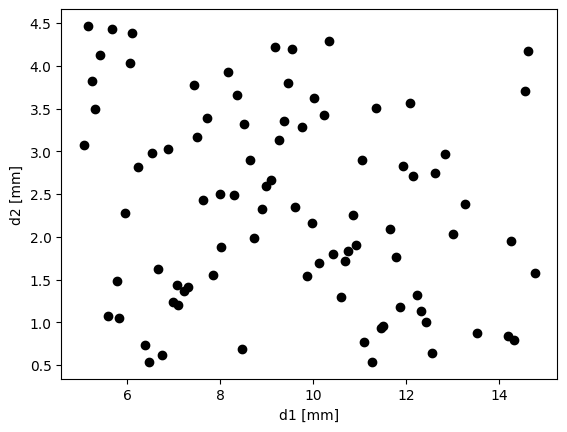

In [ ]:
# 散布図を描画
plt.plot(df['d1'], df['d2'], 'ko')
# 軸ラベルを追加
plt.xlabel('d1 [mm]')
plt.ylabel('d2 [mm]')
# グラフを表示
plt.show()

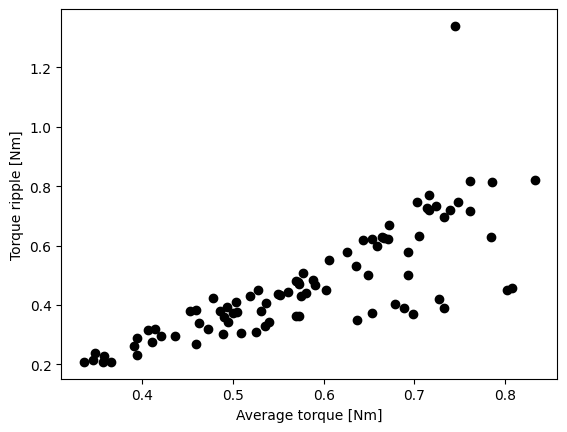

In [ ]:
# 散布図を描画
plt.plot(df['Tavg'], df['Trip'], 'ko')
# 軸ラベルを追加
plt.xlabel('Average torque [Nm]')
plt.ylabel('Torque ripple [Nm]')
# グラフを表示
plt.show()

サポートベクター回帰による回帰モデルの学習

In [ ]:

df_X = df.iloc[:,:2].copy()
df_Y = df.iloc[:,2:].copy()
X_train, X_test, Y_train, Y_test = train_test_split(df_X.values, df_Y.values, random_state=1, test_size=0.2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# スケーラを保存したいときは↓を有効化
# joblib.dump(scaler, "scaler_path.pkl")

In [ ]:
# ハイパーパラメータ最適化
t1 = time.time()
print("SVR")

# グリッドの設定
svrcs = 2**np.arange( -5, 11, dtype=float)          # C
svrepsilons = 2**np.arange( -10, 1, dtype=float)    # ε
svrgammas = 2**np.arange( -20, 11, dtype=float)     # γ
cv = 5 # 交差検証の分割数

# ガンマをグラム行列の分散が最大になるよう選択し固定
npX = np.array(X_train_scaled)
var_gram = []
for svrgamma in svrgammas:
    gram_matrix = np.exp(-svrgamma*((npX[:, np.newaxis] - npX)**2).sum(axis=2))
    var_gram.append(gram_matrix.var(ddof=1))
opt_gamma_tmp = svrgammas[np.where(var_gram == np.max(var_gram))[0][0]]

models = []
# TavgとTripのモデルを別々に実行
for i in range(2):
    print(f'\n=== training of {df_Y.columns[i]} ===')
    y_train = Y_train[:,i]

    # Cをyの平均+3σで固定
    C_tmp = y_train.mean() + 3*y_train.std()

    # εの最適値探索
    gs_eps = GridSearchCV(SVR(kernel="rbf", C=C_tmp, gamma=opt_gamma_tmp),
                        {'epsilon': svrepsilons}, cv=cv, return_train_score=True)
    gs_eps.fit(X_train_scaled, y_train)
    opt_eps = gs_eps.best_params_['epsilon']

    # Cの最適値探索
    gs_C = GridSearchCV(SVR(kernel="rbf", epsilon=opt_eps, gamma=opt_gamma_tmp),
                        {'C': svrcs}, cv=cv, return_train_score=True)
    gs_C.fit(X_train_scaled, y_train)
    opt_C = gs_C.best_params_['C']

    # γの最適値探索（なくてもいい）
    gs_gamma = GridSearchCV(SVR(kernel="rbf", epsilon=opt_eps, C=opt_C),
                            {'gamma': svrgammas}, cv=cv, return_train_score=True)
    gs_gamma.fit(X_train_scaled, y_train)
    opt_gamma = gs_gamma.best_params_['gamma']

    svr = SVR(kernel="rbf", C=opt_C, epsilon=opt_eps,
            gamma=opt_gamma).fit(X_train_scaled, y_train)

    print("\nbest model")
    print("  Training set score: {:.3f}".format(svr.score(X_train_scaled, y_train)))
    print("  Test set score: {:.3f}".format(svr.score(X_test_scaled, Y_test[:,i])))

    t2 = time.time()
    elapsed_time = t2-t1
    print("Elapsed time: {:.2f} sec".format(elapsed_time))

    models.append(svr)


SVR

=== training of Tavg ===

best model
  Training set score: 1.000
  Test set score: 1.000
Elapsed time: 4.99 sec

=== training of Trip ===

best model
  Training set score: 0.995
  Test set score: 0.931
Elapsed time: 10.23 sec


設計最適化

最適化のライブラリpymooの使い方は↓で詳しく解説しています。  
https://yuyumoyuyu.com/2021/07/23/howtousepymoo/

In [ ]:
# 最適化のパラメータ設定
params_optimization = {
    'pop_size': 10, # 集団サイズ
    'n_offsprings': 10, # 子孫の数
    'n_termination': 50, # 終了世代
    'verbose': True, # 途中結果を表示するか
    'xl': df_X.min(axis=0).values, # 入力変数の最小値
    'xu': df_X.max(axis=0).values, # 入力変数の最大値
}

In [ ]:
# 最適化途中結果の保存のためのクラス設定
class MyCallback(Callback):
    def __init__(self) -> None:
        super().__init__()
        self.data["F"] = []
        self.data["X"] = []
        # self.data["G"] = []
    def notify(self, algorithm):
        self.data["F"].append(algorithm.pop.get("F"))
        self.data["X"].append(algorithm.pop.get("X"))
        # self.data["G"].append(algorithm.pop.get("G"))

# 最適化問題の設定
class MyProblem(Problem):
    # 初期設定
    def __init__(self, models, scaler, xl, xu):
        super().__init__(
            n_var=2,
            n_obj=2,
            n_constr=0,
            xl=xl,
            xu=xu,
        )
        self.models = models
        self.scaler = scaler

    #各個体の評価
    def _evaluate(self, x, out, *args, **kwargs):
        x_scaled = scaler.transform(x) # 個体のスケーリング
        y1 = self.models[0].predict(x_scaled) # 平均トルクの計算
        y2 = self.models[1].predict(x_scaled) # トルクリプルの計算
        out["F"] = [-y1, y2] # 最小化問題を設定するため、平均トルクはマイナス倍
        # out["G"] =

In [ ]:
### 最適化の設定
# 問題の定義
problem = MyProblem(models, scaler, params_optimization['xl'], params_optimization['xu'])
# 初期個体をLHSでサンプリング
sampling = LHS()
# NSGA-IIのアルゴリズムを定義
algorithm = NSGA2(
# algorithm = GA(
    pop_size=params_optimization['pop_size'],
    sampling=sampling,
    n_offsprings=params_optimization['n_offsprings'],
    eliminate_duplicates=True
)
# 終了条件の定義
termination = get_termination("n_gen", params_optimization['n_termination'])


In [ ]:
t1 = time.time()

# 最適化の実行
res = minimize(
    problem,
    algorithm,
    termination=termination,
    seed=0,
    callback=MyCallback(),
    save_history=False,
    verbose=params_optimization['verbose'],
)
print(f'elapsed time: {time.time()-t1} sec')
result = res.algorithm.callback.data

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       10 |      5 |             - |             -
     2 |       20 |      7 |  0.0061540497 |             f
     3 |       30 |      8 |  0.2214216446 |         ideal
     4 |       40 |      9 |  0.0537845327 |         ideal
     5 |       50 |     10 |  0.0060226632 |         ideal
     6 |       60 |     10 |  0.0207641846 |             f
     7 |       70 |     10 |  0.0146252061 |         ideal
     8 |       80 |     10 |  0.0056993030 |         ideal
     9 |       90 |     10 |  0.0189338935 |             f
    10 |      100 |     10 |  0.0137670928 |             f
    11 |      110 |      9 |  0.0046817989 |         ideal
    12 |      120 |     10 |  0.0315611795 |         ideal
    13 |      130 |     10 |  0.0056853497 |         ideal
    14 |      140 |     10 |  0.0044958223 |         nadir
    15 |      150 |     10 |  0.0176940624 |             f
    16 |      160 |     10 |  0.0128081836 |            

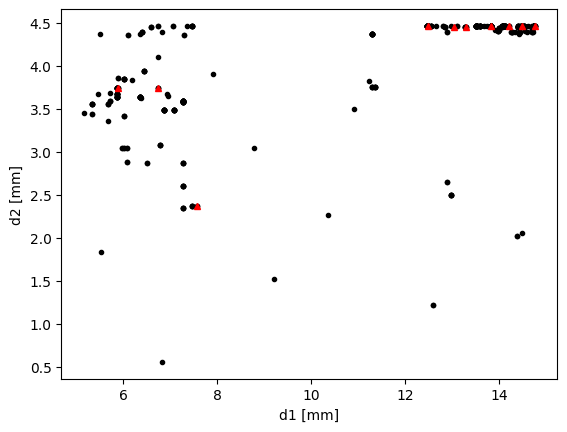

In [ ]:
# 最適化中のデータを取得
x_all = np.array(result['X'])

# 設計変数の可視化
plt.plot(x_all[:,:,0],x_all[:,:,1],'ko',ms=3) # 全世代の個体
plt.plot(x_all[-1,:,0],x_all[-1,:,1],'r^',ms=5) # 最終世代の個体
plt.xlabel('d1 [mm]')
plt.ylabel('d2 [mm]')
plt.show()

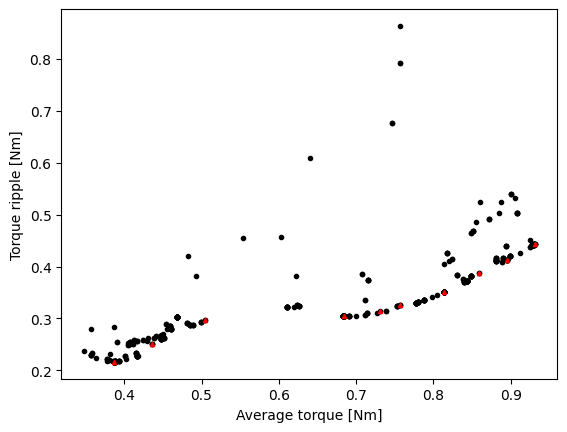

In [ ]:
# 最適化中のデータを取得
f_all = np.array(result['F'])

# 予測特性の可視化
plt.plot(-f_all[:,:,0], f_all[:,:,1],'ko',ms=3) # 全世代の個体
plt.plot(-f_all[-1,:,0], f_all[-1,:,1],'r^',ms=3) # 最終世代の個体
plt.xlabel('Average torque [Nm]')
plt.ylabel('Torque ripple [Nm]')
plt.show()

設計変数と特性の関係の可視化

In [ ]:
# 最小値と最大値を設定
min_values = df_X.min(axis=0).values
max_values = df_X.max(axis=0).values

# 格子点の数
num_points = 100

# 各軸の格子点を生成
x = np.linspace(min_values[0], max_values[0], num_points)
y = np.linspace(min_values[1], max_values[1], num_points)

# 格子点の座標の組み合わせを生成
X, Y = np.meshgrid(x, y)

In [ ]:
data_lattice = np.stack((X.flatten(),Y.flatten())).T # データの統合
data_lattice_scaled = scaler.transform(data_lattice) # 個体のスケーリング
Tavg_pred = models[0].predict(data_lattice_scaled) # 平均トルクの計算
Trip_pred = models[1].predict(data_lattice_scaled) # トルクリプルの計算


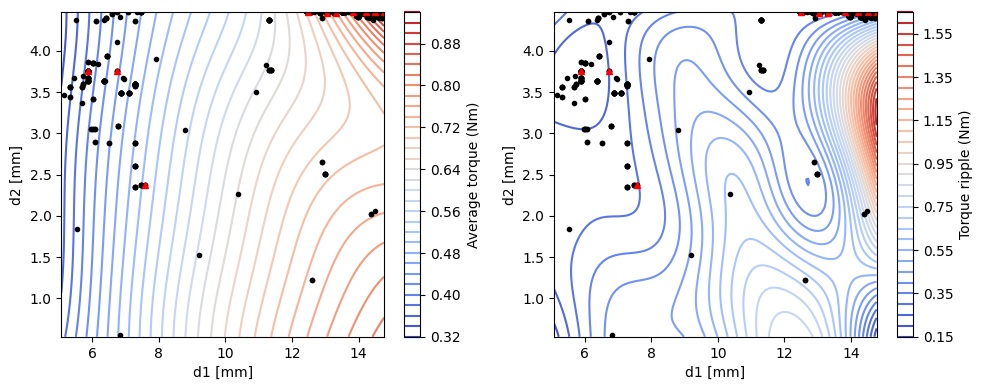

In [ ]:
# コンタープロットのカラーバーに表示するラベルを定義
clabels = ['Average torque (Nm)', 'Torque ripple (Nm)']

# 1行2列のサブプロットを作成し、描画領域 (fig) と各サブプロットの軸 (axes) を取得
fig, axes = plt.subplots(1, 2, figsize=(10,4))

# Tavg_predとTrip_predのデータを順番に描画
for i, Z in enumerate([Tavg_pred, Trip_pred]):
    # Zを指定の形状に再形成
    Z = Z.reshape(num_points, num_points)

    # i番目のサブプロットにコンタープロットを描画し、そのインスタンスを取得
    contour = axes[i].contour(X, Y, Z, levels=30, cmap='coolwarm')

    # i番目のサブプロットにカラーバーを追加し、そのインスタンスを取得
    cbar = fig.colorbar(contour, ax=axes[i])

    # i番目のサブプロットに散布図を追加
    axes[i].plot(x_all[:,:,0],x_all[:,:,1],'ko',ms=3)
    axes[i].plot(x_all[-1,:,0],x_all[-1,:,1],'r^',ms=5)

    # i番目のサブプロットのx軸、y軸にラベルを追加
    axes[i].set_xlabel('d1 [mm]')
    axes[i].set_ylabel('d2 [mm]')

    # i番目のサブプロットのカラーバーにラベルを追加
    cbar.set_label(clabels[i])

# サブプロット間のスペースを自動調整
fig.tight_layout()
